# Make Input_csv

In [150]:
import pandas as pd
import numpy as np
import os
import random
import gc

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
import pickle
from datetime import datetime
from tqdm.notebook import tqdm
import time
from IPython.display import Audio

## 1. Data Load

In [2]:
# Load Train Data
data_dir = '../input/data/train_dataset'
csv_file_path = os.path.join(data_dir, 'train_data.csv')
df = pd.read_csv(csv_file_path)

In [3]:
# Load Test Data
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

In [4]:
# Concat Train, Test Data
total_df = pd.concat([df, test_df[test_df.answerCode!=-1]], ignore_index=True)
assessmentItemID_mean_dict = total_df.groupby('assessmentItemID').mean().to_dict()

In [5]:
df = total_df

## 2. Feature Engineering Func

### elapsed_time & lag_time

In [6]:
# make elapsed_time & lag_time
def convert_time(s):
    timestamp = time.mktime(datetime.strptime(s, '%Y-%m-%d %H:%M:%S').timetuple())
    return int(timestamp)

def create_elapsed_time(df):
    prev_timestamp = df.groupby(['userID', 'testId'])[['time_stamp']].shift()
    df['elapsed_time'] = df['time_stamp'] - prev_timestamp['time_stamp']
    df['elapsed_time'] = df['elapsed_time'].fillna(0)
    return df

def create_lag_time(df):
    start_end_id_by_user_test = df.groupby(['userID','testId']).apply(lambda x: (x.index.values[0], x.index.values[-1])).reset_index()
    start_end_id_by_user_test = start_end_id_by_user_test.sort_values(by=[0]).reset_index(drop=True)
    start_row_id_by_user = start_end_id_by_user_test.groupby('userID').apply(lambda x: x.index.values[0])
    
    lag_time_list = [0]*len(df)
    for start_row, end_row in tqdm(start_end_id_by_user_test [0][1:]):
        start_time = df.time_stamp[start_row]
        prev_time = df.time_stamp[start_row-1]
        lag_time = start_time - prev_time
        lag_time_list[start_row:end_row+1] = [lag_time]*(end_row-start_row+1)
    
    # 사용자가 바뀌는 부분 첫 시험지 lag_time은 0으로 변경
    for user_start_idx in tqdm(start_row_id_by_user):
        start, end = start_end_id_by_user_test .loc[user_start_idx][0]
        lag_time_list[start:end+1] = [0]*(end-start+1)
        
    df['lag_time'] = lag_time_list
    
    return df

# lag_time old
def create_lag_time_old(df):
    lag_time_list = []
    for user_id in df.userID.unique():
        lag_time = 0
        end_time = 0
        user_df = df[df.userID == user_id]
        test_ids_df = user_df.groupby('testId')
        for testid in user_df.testId.unique():
            time_stamps = test_ids_df.get_group(testid).time_stamp.values
            if end_time:
                lag_time = time_stamps[0] - end_time
            for i in range(len(time_stamps)):
                lag_time_list.append(lag_time)
                if i != 0:
                    end_time = time_stamps[i]
    df['lag_time_old'] = lag_time_list
    return df

### user_recent_acc

In [7]:
# make user_recent_acc
def create_recent_acc(df, n=5):
    def custom(pr, cnt, n):
        if cnt < n:
            return 0
        else:
            return pr
    tmp_df = df.copy()
    user_start_idx = df['userID'].diff() > 0
    tmp_df['prior_ans_cnt']  = tmp_df.groupby('userID')['answerCode'].cumsum().shift(fill_value=0)
    tmp_df['shift_prior_ans_cnt'] = tmp_df.groupby('userID')['answerCode'].cumsum().shift(fill_value=0)
    tmp_df.loc[user_start_idx, ['prior_ans_cnt','shift_prior_ans_cnt']] = 0
    tmp_df['shift_prior_ans_cnt'] = tmp_df['shift_prior_ans_cnt'].shift(n)
    tmp_df['content'] = [1]*len(tmp_df)
    tmp_df['prior_quest_cnt'] = tmp_df.groupby('userID')['content'].cumsum().shift(fill_value=0)
    tmp_df['prior_quest_cnt'] = tmp_df['prior_quest_cnt'].apply(lambda x: n if x>n else x)
    tmp_df.loc[user_start_idx, ['prior_quest_cnt']] = 0
    tmp_df['shift_prior_ans_cnt'] = tmp_df.apply(lambda x: custom(x['shift_prior_ans_cnt'], x['prior_quest_cnt'], n), axis=1)
    tmp_df['cnt'] = tmp_df['prior_ans_cnt'] - tmp_df['shift_prior_ans_cnt'] 
    df[f'user_recent_acc_{n}'] = (tmp_df['cnt'] / tmp_df['prior_quest_cnt']).fillna(0)
    return df

### sum_rel_point

In [8]:
# make sum_rel_point
from tqdm.notebook import tqdm

def fill_rel_point(df):
    arr = np.zeros(len(df))
    start_idx = 0

    for i in tqdm(range(len(df))):
        row = df.iloc[i, :].copy()
        answer = row['answerCode']
        item_ans_rate = row['item_ans_rate']

        if answer == 1:
            arr[i] = 1 - item_ans_rate
        elif answer == 0:
            arr[i] = - item_ans_rate
        elif answer == -1:
            
            avg_rel_point = np.mean(arr[start_idx : i])
            start_idx = i + 1 
            arr[i] = avg_rel_point

    df['rel_point'] = pd.Series(arr)
    return df

def sum_point(df):
    grouped = df.groupby('userID')['rel_point']
    arr = np.zeros(len(df))
    start_idx = 0
    cnt = 0
    for _, group in tqdm(grouped):
        cnt += 1
        point_sum = group.iloc[:len(group)-1].sum()
        arr[start_idx:start_idx+len(group)] = point_sum
        start_idx = start_idx + len(group)

    df['sum_rel_point'] = pd.Series(arr)
    return df

### knowledgetag_stroke

In [9]:
# tag 연속으로 나온 횟수
def knowledgetag_storke_feat_eng(df):
    knowledgetags = df.KnowledgeTag
    knowledgetag_stroke = np.zeros(knowledgetags.shape)
    
    for i, k in enumerate(knowledgetags):
        if i == 0:
            continue
    
        if k == knowledgetags[i-1]:
            knowledgetag_stroke[i] = knowledgetag_stroke[i-1] + 1
            
    df['knowledgetag_stroke'] = knowledgetag_stroke
    return df

### testPre & testPost

In [10]:
def testId_feat_eng(df, total_df):
    
    total_df['testPre'] = total_df.testId.map(lambda x: x[1:4])
    total_df['testPost'] = total_df.testId.map(lambda x: x[-3:])
    
    df['testPre'] = df.testId.map(lambda x: x[1:4])
    df['testPost'] = df.testId.map(lambda x: x[-3:])
    
    
    feat_test_preId = total_df.groupby('testPre')['answerCode'].agg(['mean', 'sum'])
    feat_test_preId.columns = ["test_preId_mean", 'test_preId_sum']
    feat_test_postId = total_df.groupby('testPost')['answerCode'].agg(['mean', 'sum'])
    feat_test_postId.columns = ["test_postId_mean", 'test_postId_sum']
    
    df = pd.merge(df, feat_test_preId, on=['testPre'], how="left")
    df = pd.merge(df, feat_test_postId, on=['testPost'], how="left")
    
    df['testPre'] = df.testPre.map(int)
    df['testPost'] = df.testPost.map(int)
    
    return df

### test_time

In [170]:
def seperate_time(t):
    if t.hour < 6:
        # 새벽
        return 0
    elif t.hour < 12:
        # 오전
        return 1
    elif t.hour < 18:
        # 오후
        return 2
    else:
        # 밤
        return 3

def time_feat_eng(df, total_df):
    timestamps = pd.to_datetime(total_df.Timestamp)
    timestamps = timestamps.map(seperate_time)
    total_df['test_time'] = timestamps
    timestamps = pd.to_datetime(df.Timestamp)
    timestamps = timestamps.map(seperate_time)
    df['test_time'] = timestamps
    feat_test_time = total_df.groupby('test_time')['answerCode'].agg(['mean', 'sum'])
    feat_test_time.columns = ["test_time_mean", 'test_time_sum']
    df = pd.merge(df, feat_test_time, on=['test_time'], how="left")
    # Target Encoding + Smoothing
    df['test_time'] = df['test_time'].map(lambda x: (feat_test_time.iloc[x]['test_time_mean'] + feat_test_time['test_time_mean'].mean())/2)
    return df

### ktag_acc

In [91]:
# 유저별 ktag별 정답률
def user_ktag_acc(df):
    def rate(values):
        return sum(values) / len(values)
    df['user_ktag_acc'] = df.groupby(['userID', 'KnowledgeTag']).answerCode.transform(rate)
    return df

def user_ktag_mean(df):
# 유저별 ktag별 정답률과 ktag 전체 정답률(tag_mean) 평균
    df['user_ktag_mean'] = (df['tag_mean'] + df['user_ktag_acc']) / 2
    return df

### feature_engineering 함수

In [104]:
def feature_engineering(df):
    
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_correct_answer'] = df['user_correct_answer'].fillna(0)
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']
    df['user_acc'] = df['user_acc'].fillna(0)

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum', 'std'])
    correct_t.columns = ["test_mean", 'test_sum', 'test_std']
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum', 'std'])
    correct_k.columns = ["tag_mean", 'tag_sum', 'tag_std']

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    
    # custom features
    
    
    # item_ans_rate: 문항별 정답률
    df['item_ans_rate'] = df.assessmentItemID.map(assessmentItemID_mean_dict['answerCode'])
    
    # elapsed time & lag_time
    df['time_stamp'] = df['Timestamp'].apply(convert_time)
    df = create_elapsed_time(df)
    df = create_lag_time(df)
    
    # user_recent_acc
    for i in tqdm([5, 10, 30, 50, 100]):
        df = create_recent_acc(df, n=i)
    
    # sum_rel_point
    df = fill_rel_point(df)
    df = sum_point(df)
    # normalize sum_rel_point
    max_, min_ = max(df['sum_rel_point']), min(df['sum_rel_point'])
    df['sum_rel_point'] = (df['sum_rel_point'] - min_) / (max_ - min_)
    
    # user_ktag_acc
    df = user_ktag_acc(df)
    
    # knowledgetag_stroke
    df = knowledgetag_storke_feat_eng(df)
    
    # testPre & testPost
    total_df = df.copy()
    df = testId_feat_eng(df, total_df)
    
    # test_time_mean & test_time_sum
    total_df = df.copy()
    df = time_feat_eng(df, total_df)
    
    return df

## 3. Train/Test FE

In [ ]:
%%time
df = feature_engineering(df)
# df = create_lag_time_old(df) # lag_time 예전 함수
# df.to_csv("df/df.csv", index=False) # df -> csv파일

In [ ]:
test_df = feature_engineering(test_df)
# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]
# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

In [167]:
# 사용할 Feature 설정
FEATS = ['KnowledgeTag', 'user_acc', 'test_mean', 'test_sum', 'tag_sum', 'tag_mean',
         'elapsed_time', 'lag_time_old', 'item_ans_rate', 'test_time',
         'user_recent_acc_5', 'user_recent_acc_10', 'user_recent_acc_30', 'user_recent_acc_50', 'user_recent_acc_100',
        'sum_rel_point', 'knowledgetag_stroke',# 'user_ktag_mean',
         'testPre', 'testPost', 'test_postId_mean', 'test_preId_mean',
         'test_postId_sum']#'test_preId_sum']

# X, y 값 분리
y_train = df['answerCode']
train = df.drop(['answerCode'], axis=1)

## 4. 훈련 및 검증

### LightGBM cross validation out of fold train/predict 함수 정의

In [97]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [164]:
def make_lgb_oof_prediction(train, y, test, features, model_params=None, folds=10):
    x_train = train[features]
#     print('x_train.shpae', x_train.shape)
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score_auc = 0
    score_acc = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    kf = KFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(kf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        print(f'fold: {fold+1}, x_train.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        # LightGBM 데이터셋 선언
        dtrain = lgb.Dataset(x_tr, label=y_tr)
        dvalid = lgb.Dataset(x_val, label=y_val)
        
        # LightGBM 모델 훈련
        clf = lgb.train(
            model_params,
            dtrain,
            valid_sets=[dtrain, dvalid], # Validation 성능을 측정할 수 있도록 설정
            verbose_eval=100
        )

        # Validation 데이터 예측
        val_preds = clf.predict(x_val)
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds
        
        # 폴드별 Validation 스코어 측정
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score_auc += roc_auc_score(y_val, val_preds) / folds
        score_acc += accuracy_score(y_val, np.where(val_preds >= 0.5, 1, 0)) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict(x_test) / folds
        
        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = clf.feature_importance()

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score_auc}") # 폴드별 Validation 스코어 출력
    print(f"Mean ACC = {score_acc}")
    print(f"\nOOF ACC = {accuracy_score(y, np.where(y_oof >= 0.5, 1, 0))}")
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
        
    # 폴드별 피처 중요도 평균값 계산해서 저장 
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds, fi

### 피처 중요도 플롯 함수 정의

In [148]:
def plot_feature_importances(df, n=20, color='blue', figsize=(12,8)):
    # 피처 중요도 순으로 내림차순 정렬
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # 피처 중요도 정규화 및 누적 중요도 계산
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    plt.style.use('fivethirtyeight')
    # 피처 중요도 순으로 n개까지 바플롯으로 그리기
    df.loc[:n, :].plot.barh(y='importance_normalized', 
                            x='feature', color=color, 
                            edgecolor='k', figsize=figsize,
                            legend=False)

    plt.xlabel('Normalized Importance', size=18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size=18)
    plt.gca().invert_yaxis()
    
    return df

### Hyperparameter 선언

In [171]:
SEED = 42
params = {'objective': 'binary',
          'metric': 'auc',
          'boosting_type': 'gbdt',
          'seed': 42,
          'num_leaves': 45,
          'learning_rate': 0.1
         }

In [169]:
%%time
y_oof, test_preds, fi = make_lgb_oof_prediction(train, y_train, test_df, FEATS, params)

fold: 1, x_train.shape: (2273360, 22), x_val.shape: (252596, 22)
[LightGBM] [Info] Number of positive: 1488388, number of negative: 784972
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3915
[LightGBM] [Info] Number of data points in the train set: 2273360, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654708 -> initscore=0.639801
[LightGBM] [Info] Start training from score 0.639801
[100]	training's auc: 0.845867	valid_1's auc: 0.845255
Fold 1 | AUC: 0.8452549633326895
--------------------------------------------------------------------------------
fold: 2, x_train.shape: (2273360, 22), x_val.shape: (252596, 22)
[LightGBM] [Info] Number of positive: 1488232, number of negative: 785128
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

### Feature importance plot

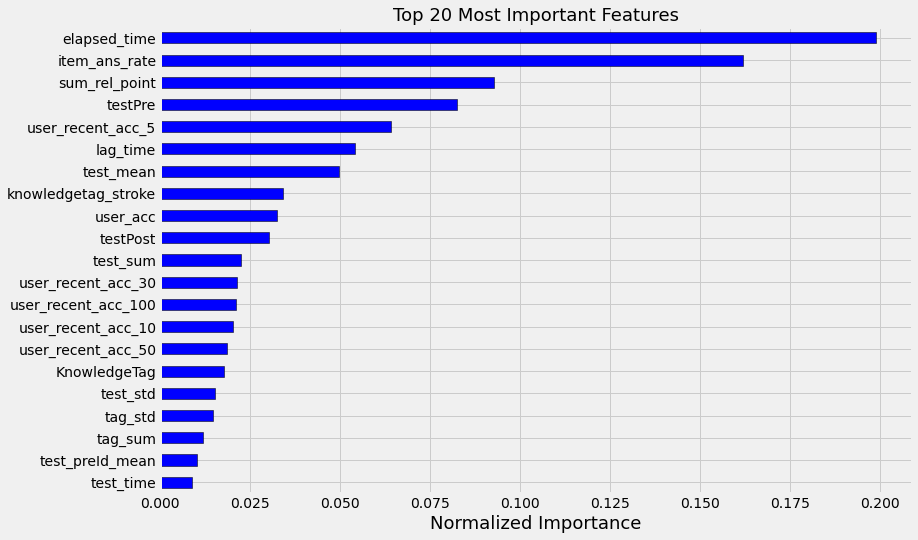

In [152]:
# sns.distplot(test_preds)
# plt.show()
fi_lgb = plot_feature_importances(fi)

## 5. Submit

In [141]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "0608_kfold.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(test_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/0608_kfold.csv
